# 0.0 IMPORTS

In [1]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import umap.umap_ as umap

import inflection

from IPython.display     import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from matplotlib import pyplot        as plt
from sklearn    import cluster       as c
from sklearn    import preprocessing as pp
from sklearn    import metrics       as m
from plotly     import express       as px

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 30
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Dataset

In [3]:
# Load dataset
df_raw = pd.read_csv( '/home/jeffsmedines/repos/loyalty_program/data/raw/Ecommerce.csv', encoding='unicode_escape' )

# Drop NA Column
df_raw = df_raw.drop( columns=['Unnamed: 8'] )

# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
columns = df1.columns
new_columns = [inflection.underscore( x ) for x in columns]
df1.columns = new_columns

## 1.2 Data Dimensions

In [6]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' )

Number of Rows: 541909
Number of Columns: 8


## 1.3 Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA's

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA's

In [9]:
# Remove NA's
df1 = df1.dropna( subset=['description', 'customer_id'] )
print( f'Removed data: {1 - (df1.shape[0] / df_raw.shape[0]):.2%}' )

Removed data: 24.93%


In [10]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change Data Types

In [11]:
# Invoice Date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# Customer ID
df1['customer_id'] = df1['customer_id'].astype( int )

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [14]:
# Central tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# Dispersion 
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concat
ds = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ds.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ds

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### <font color='red'> 1.7.2 Numerical Attributes - Investigating </font>

1. Quantity negativa. (talvez seja devolução)
2. Preço unitário igual a zero. (conferir se foi uma promoção)

### 1.7.2 Categorical Attributes

#### Invoice Number

In [15]:
# Invoice number with letters and unique values
a = len(cat_attributes.loc[cat_attributes['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'invoice_no'].drop_duplicates())

# Invoice number with letters
b = len(cat_attributes.loc[cat_attributes['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'invoice_no'])

# Quantity negative in rows with invoice number with letters
c11 = len(df1.loc[df1['quantity'] < 0, 'invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ))

print( f'Total number of unique invoice with letters: { a }' )
print( f'Total number of invoice with letters: { b }' )
print( f'Total number of negative quantity: { c11 }' )

Total number of unique invoice with letters: 3654
Total number of invoice with letters: 8905
Total number of negative quantity: 8905


#### Stock Code

In [16]:
# Stock code with letters
cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool(re.search( '[^0-9]+', x ) ) ), 'stock_code'].head()

0     85123A
2     84406B
3     84029G
4     84029E
45      POST
Name: stock_code, dtype: object

In [17]:
# Stock code only with letter
cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool(re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Action: remove these codes

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

#### Description

In [18]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [19]:
# Action: delet description because can't create any feature

#### Country

In [20]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

# 2.0 DATA FILTERING

In [21]:
df2 = df1.copy()

## 2.1 Categorical Attributes Filtering

In [22]:
# Stock code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'C2', 'DOT', 'CRUK'] )]

# Drop description
df2 = df2.drop( columns='description', axis=1 )

# Map
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'] )]

In [23]:
df2.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,6,2016-11-29,3.39,17850,United Kingdom


## 2.2 Numerical Attributes Filtering

In [24]:
# Unit price < 0
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# Quantity
df2_returns = df2.loc[df2['quantity'] < 0, :].copy()
df2_purchase = df2.loc[df2['quantity'] > 0, :].copy()

# 3.0 FEATURE ENGINEERING

In [25]:
df3 = df2.copy()

## 3.1 Feature Creation

In [26]:
df_ref = df3.drop( columns=['invoice_no', 'stock_code', 'quantity',
                            'invoice_date', 'unit_price','country'], 
                             axis=1 ).drop_duplicates( ignore_index=True )
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [27]:
# Gross Revenue
df2_purchase['gross_revenue'] = df2_purchase['quantity'] * df2_purchase['unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

# Recency
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency.drop( columns=['invoice_date'], axis=1 )
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

# Frequency
df_freq = df2_purchase[['invoice_no', 'customer_id']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

# Avg ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, how='left', on='customer_id' )

# # Returns
# df_returns = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename( columns={'invoice_no': 'returns'} )
# df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
# df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0

In [28]:
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [29]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


In [30]:
# # Gross Revenue
# df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

# # Monetary
# df_monetary = df3[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
# df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

# # Recency
# df_recency = df3[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
# df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
# df_recency = df_recency.drop( columns=['invoice_date'], axis=1 )
# df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

# # Frequency
# df_freq = df3[['invoice_no', 'customer_id']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
# df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

# # Avg ticket
# df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'} )

# df_ref = pd.merge( df_ref, df_avg_ticket, how='left', on='customer_id' )

# 4.0 EXPLORATORY DATA ANALYSIS

In [31]:
df4 = df_ref.dropna().copy()

# 5.0 DATA PREPARATION

In [32]:
df5 = df4.copy()

In [33]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


In [34]:
ss = pp.MinMaxScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
# df5['returns'] = ss.fit_transform( df5[['returns']] )

In [35]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.019301,0.997319,0.160976,0.000208
1,13047,0.011567,0.150134,0.039024,0.000218
2,12583,0.024009,0.005362,0.068293,0.000347
3,13748,0.003384,0.254692,0.019512,0.000412
4,15100,0.003125,0.892761,0.009756,0.003756


# 6.0 FEATURE SELECTION

In [36]:
df6 = df5.copy()

# 7.0 HYPERPARAMETER FINE TUNING

In [37]:
X = df6.drop( columns=['customer_id'] ).copy()

In [38]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.019301,0.997319,0.160976,0.000208
1,0.011567,0.150134,0.039024,0.000218
2,0.024009,0.005362,0.068293,0.000347
3,0.003384,0.254692,0.019512,0.000412
4,0.003125,0.892761,0.009756,0.003756


## 7.1 Within-Cluster Sum of Square (WSS)

In [39]:
clusters = [2, 3, 4, 5, 6, 7]

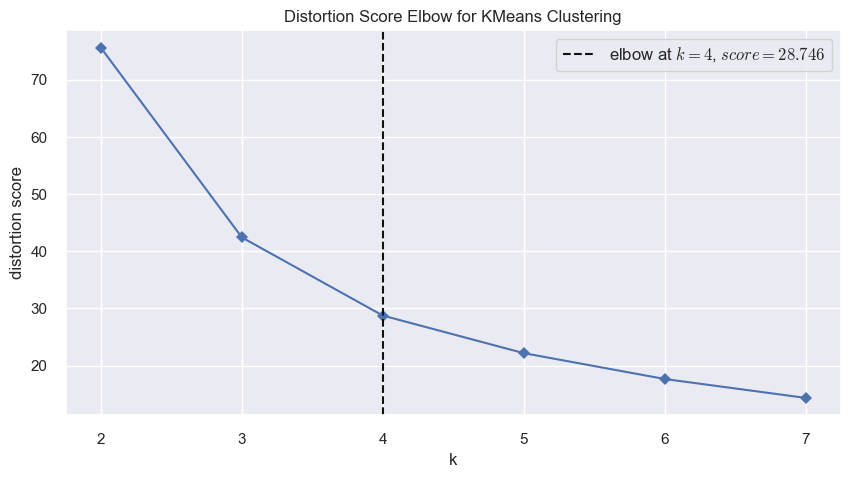

In [40]:
kmeans = KElbowVisualizer( c.KMeans( n_init=10 ), k=clusters,  timings=False )
kmeans.fit( X )
kmeans.show();

## 7.2 Silhouette Score

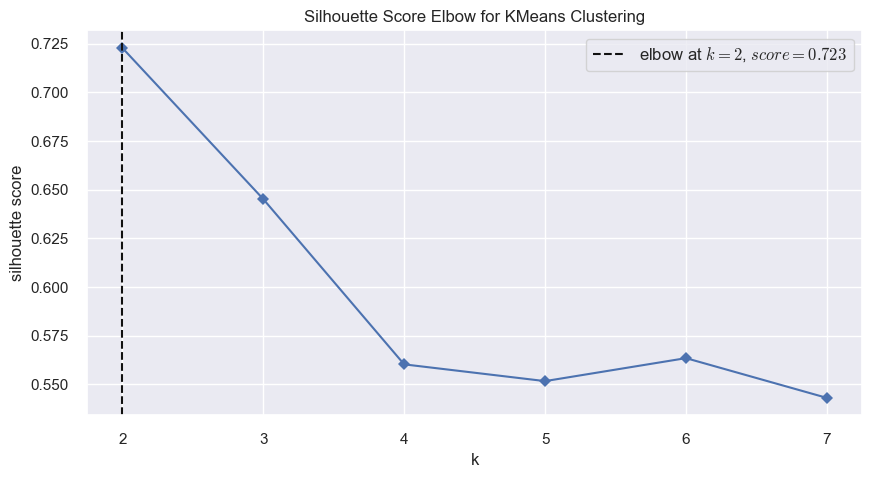

In [41]:
kmeans = KElbowVisualizer( c.KMeans( n_init=10 ), metric='silhouette', k=clusters,  timings=False )
kmeans.fit( X )
kmeans.show();

## 7.3 Silhouette Analysis

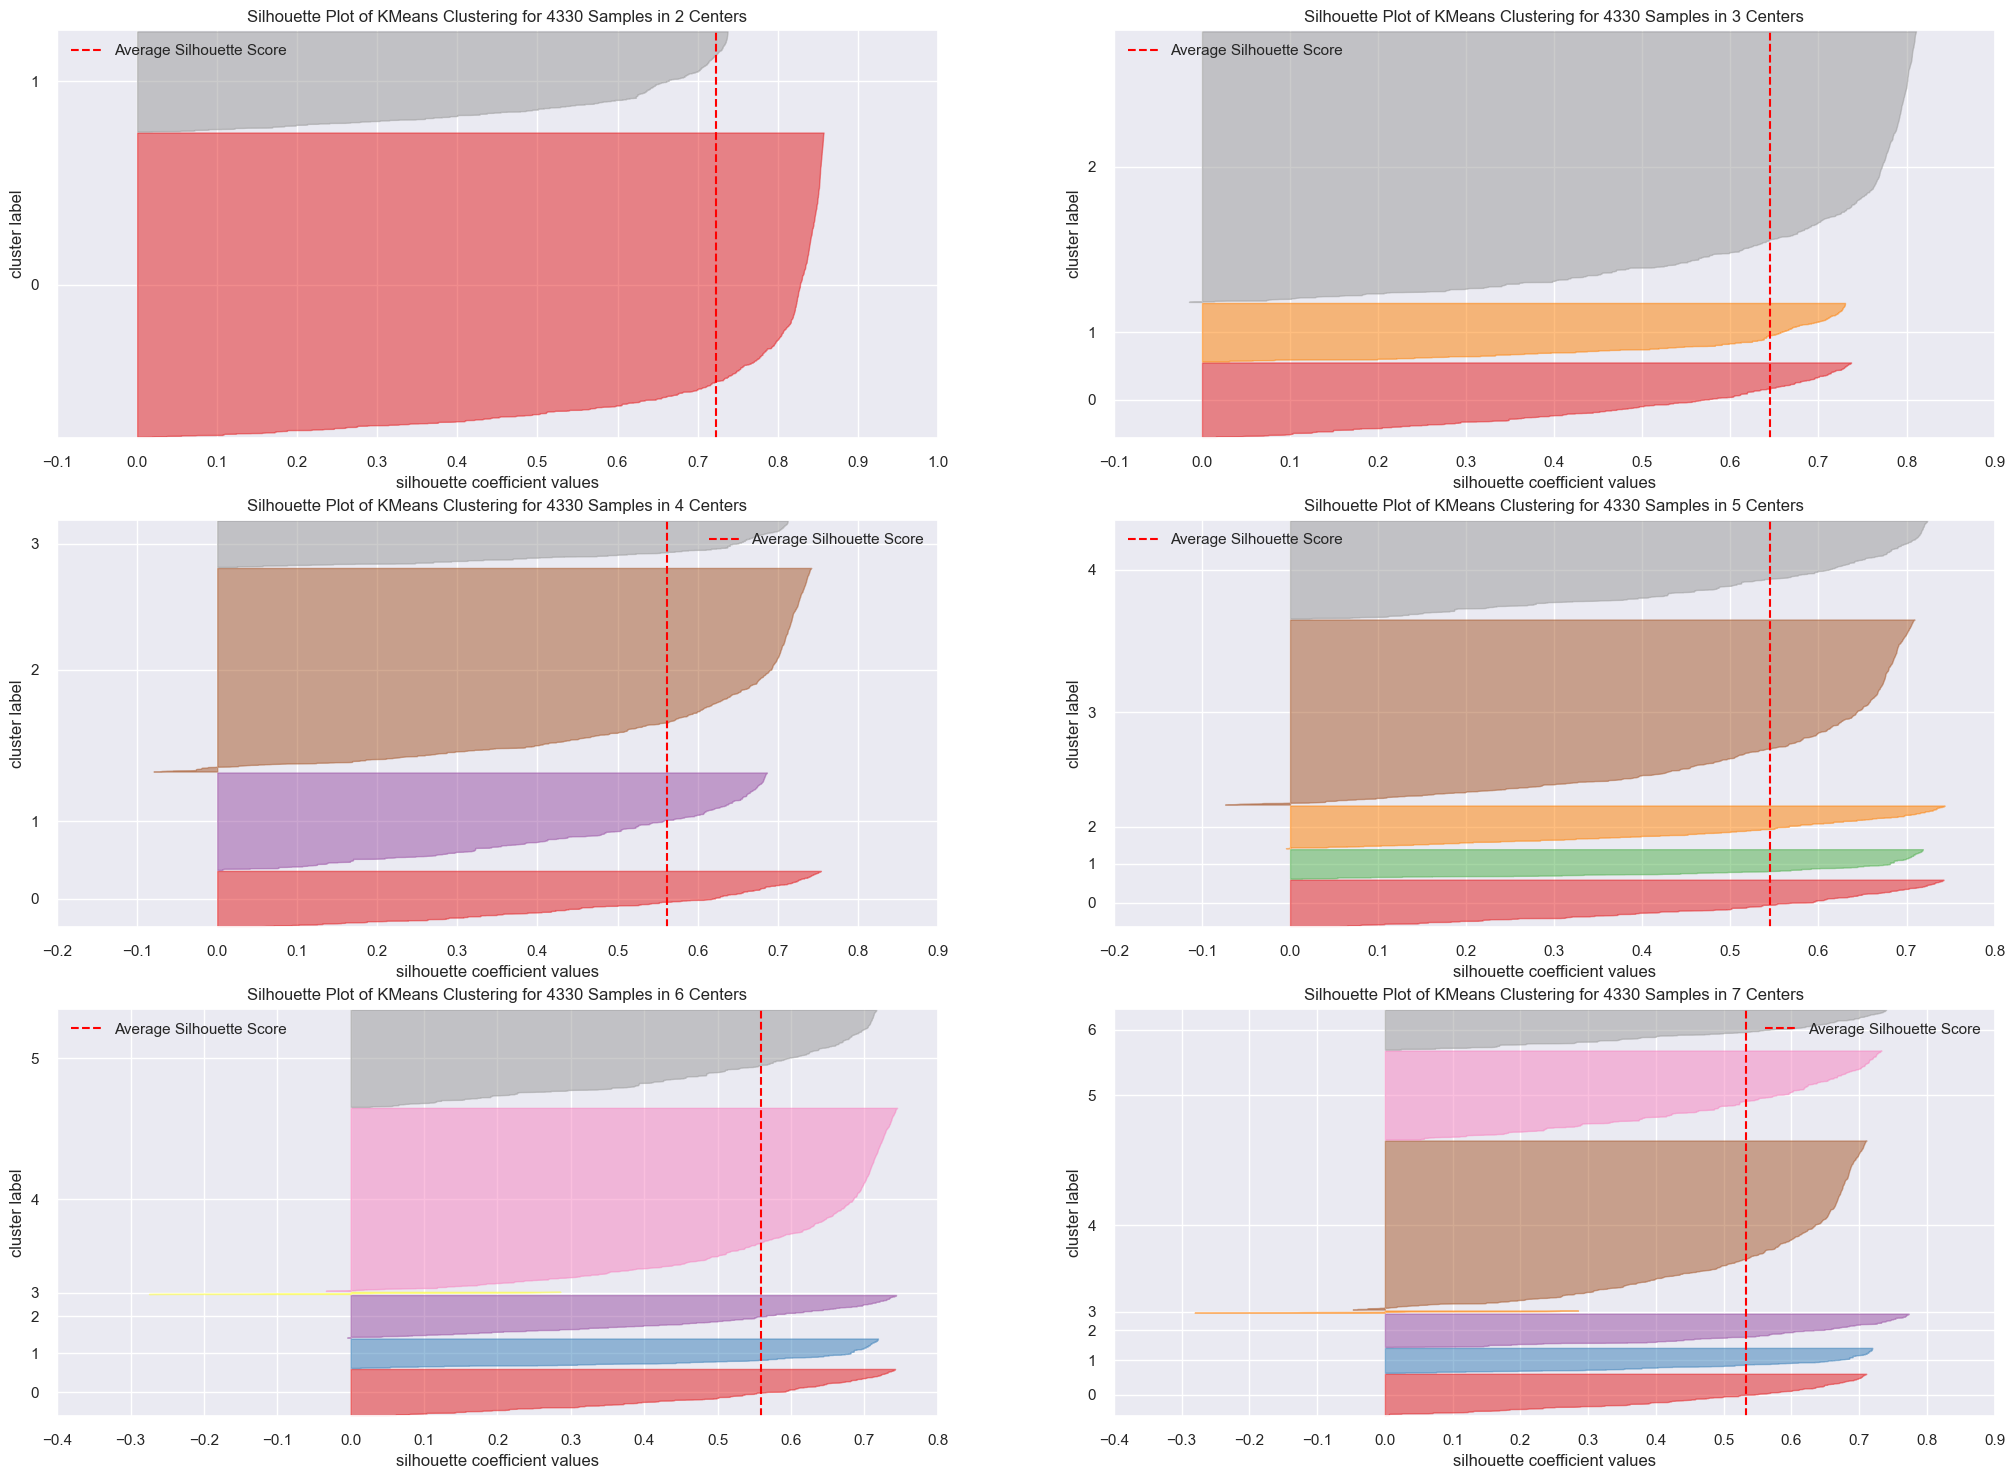

In [42]:
fig, ax = plt.subplots( 3, 2, figsize=( 25, 18 ) )


for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, color='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 8.0 MODEL TRAINING

In [43]:
# Model Definition
k = 4
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# Model Training
kmeans.fit( X.values )

# Clustering
labels = kmeans.labels_

In [44]:
# WSS
print( f'WSS value: {kmeans.inertia_:.2f}' )

# SS
print( f'SS value: {m.silhouette_score( X, labels ):.4f}' )

WSS value: 28.78
SS value: 0.5612


# 9.0 CLUSTER ANALYSIS

In [45]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,3
1,13047,0.011567,0.150134,0.039024,0.000218,1
2,12583,0.024009,0.005362,0.068293,0.000347,2
3,13748,0.003384,0.254692,0.019512,0.000412,1
4,15100,0.003125,0.892761,0.009756,0.003756,3


## 9.1 Visualization Inspection

In [46]:
# fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
# fig.show()

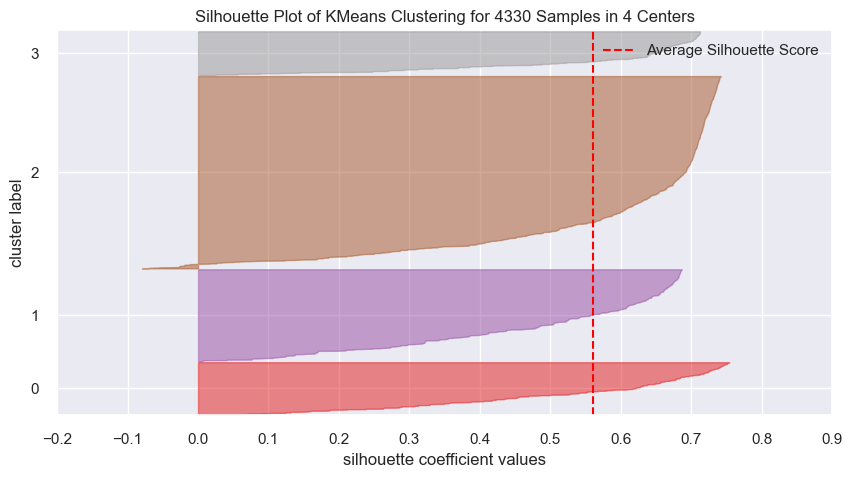

In [47]:
visualizer = SilhouetteVisualizer( kmeans, color='yellowbrick' )
visualizer.fit( X.values )
visualizer.finalize()

## 9.2 2D Plot

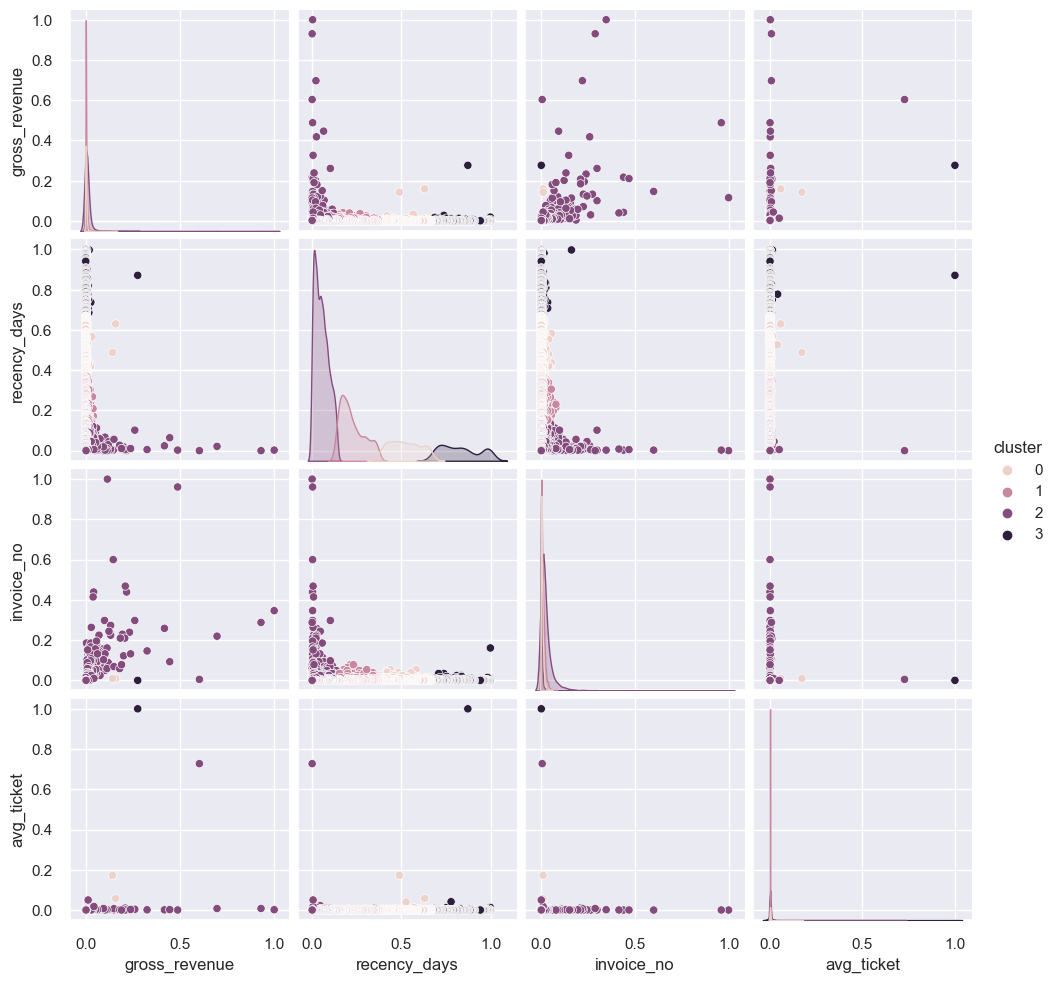

In [48]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster' )

## 9.3 UMAP - t-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

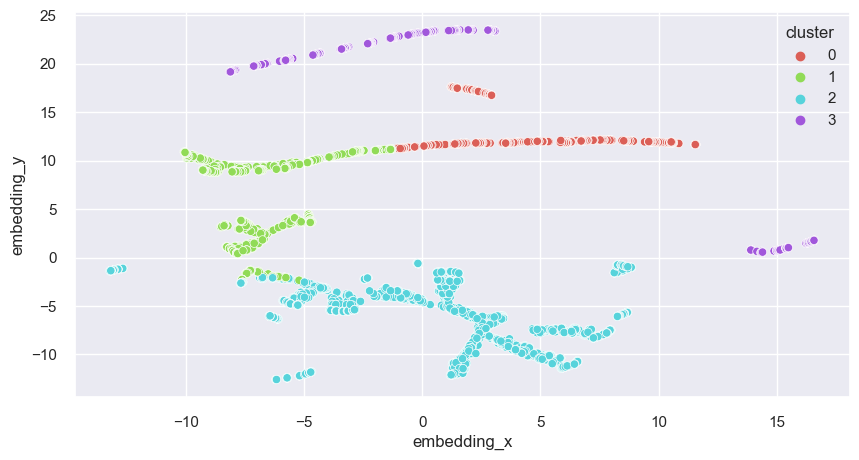

In [49]:
reducer = umap.UMAP( n_neighbors=40, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y',
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ), data=df_viz)

## 9.2 Cluster Profile

In [50]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# Avg gross revenue 
df_avg_gross = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross, how='inner', on='cluster' )

# Avg recency days
df_avg_recency = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency, how='inner', on='cluster' )

# Avg invoice_no
df_avg_invoice = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice, how='inner', on='cluster' )

# Avg ticket by cluster
df_avg_ticket_cluster = df9[['cluster', 'avg_ticket']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_ticket_cluster, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,596,13.764434,0.002523,0.517930,0.004207,0.000818
1,1,1047,24.180139,0.003588,0.223096,0.007767,0.000382
2,2,2188,50.531178,0.011448,0.052501,0.026129,0.000705
3,3,499,11.524249,0.002018,0.827661,0.001672,0.002538


 ### Cluster 1 (Insiders)
    - Representam 0,13% da base.
    - Gastaram $182181,98 na média.
    - Compraram a última vez a 7 dias na média.
    - Compraram 89 itens na média.
    
    
    
### Cluster 2 
    - Representam 99,15% da base.
    - Gastaram em média $1372,57.
    - Compraram a última vez 92 dias atrás na média.
    - Compraram 4 itens na média.



    
### Cluster 3
    - Representam 0,70% da base.
    - Gastaram $40543,51 na média.
    - Compraram a última vez 13 dias atrás na média.
    - Compraram 53 unidades na média.

# 10.0 DEPLOY TO PRODUCTION